In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from tqdm import tqdm_notebook as tqdm

In [90]:
def proportion(x, mu0, mu1, sigma, N, acorn = 1):
    np.random.seed(acorn)
    
    f0x = norm.pdf(x, mu0, sigma)
    f1x = norm.pdf(x, mu1, sigma)
    
    labels = np.zeros(N)
    
    for i in range(N):
        coin_flip = np.random.binomial(1, 0.5)
        if coin_flip < 0.5:
            z = np.random.normal(mu0, sigma, 1)[0]
        else:
            z = np.random.normal(mu1, sigma, 1)[0]
            
        f0z = norm.pdf(z, mu0, sigma)
        f1z = norm.pdf(z, mu1, sigma)
        pi0 = f0z / (f0z + f1z)
            
        labels[i] = np.argmax([pi0 * f0x, (1 - pi0) * f1x])
            
    return np.sum(labels)/N

def L_star_linear(pi0, mu0, mu1, sigma, label = -1):
    m = (mu0 + mu1)/2
    left = pi0 * (1 - norm.cdf(m, mu0, sigma))
    right = (1 - pi0) * norm.cdf(m, mu1, sigma)
    
    #if label == -1:
    return left + right
    #elif label == 0:
    #    return left
    #else:
    #    return right
    

def product_classifier(pi0, mu0, mu1, sigma, M, acorn = 2):
    np.random.seed(acorn)
    
    misclassified_count = 0
    for i in range(M):
        label = np.random.binomial(1, pi0)
        if label == 0:
            z = np.random.normal(mu0, sigma, 1)[0]
            x = np.random.normal(mu0, sigma, 1)[0]
        else:
            z = np.random.normal(mu1, sigma, 1)[0]
            x = np.random.normal(mu1, sigma, 1)[0]
            
        f0z = norm.pdf(z, mu0, sigma)
        f1z = norm.pdf(z, mu1, sigma)
        
        f0x = norm.pdf(x, mu0, sigma)
        f1x = norm.pdf(x, mu1, sigma)
        
        prediction = np.argmax(np.array([pi0*f0z*f0x, (1 - pi0)*f1z*f1x]))
        
        if prediction != label:
            misclassified_count += 1
            
    return misclassified_count/M
    
def updated_prior_loss(pi0, mu0, mu1, sigma, M, acorn = 2):
    np.random.seed(acorn)
    
    misclassified_count = 0
    for i in range(M):
        label = np.random.binomial(1, pi0)
        if label == 0:
            z = np.random.normal(mu0, sigma, 1)[0]
            x = np.random.normal(mu0, sigma, 1)[0]
        else:
            z = np.random.normal(mu1, sigma, 1)[0]
            x = np.random.normal(mu1, sigma, 1)[0]
            
        f0z = norm.pdf(z, mu0, sigma)
        f1z = norm.pdf(z, mu1, sigma)
        
        f0x = norm.pdf(x, mu0, sigma)
        f1x = norm.pdf(x, mu1, sigma)
        
        new_pi0 = f0z / (f0z + f1z)
        
        prediction = np.argmax(np.array([new_pi0*f0x, (1 - new_pi0)*f1x]))
        
        if prediction != label:
            misclassified_count += 1
            
    return misclassified_count/M

def parameter_estimates(X, Y, tied = True):
    n = len(Y)
    
    class0_idx = Y == 0
    class1_idx = Y == 1
    
    X0 = X[class0_idx]
    X1 = X[class1_idx]
    
    mu0_hat = np.mean(X0)
    mu1_hat = np.mean(X1)
    
    v0_hat = np.var(X0, ddof = 1)
    v1_hat = np.var(X1, ddof = 1)
    
    if tied:
        v_hat = ((len(X0) - 1)*v0_hat + (len(X1) - 1)*v1_hat) / (n - 2)
        return mu0_hat, mu1_hat, np.sqrt(v_hat)
    else:
        return mu0_hat, mu1_hat, np.sqrt(v0_hat), np.sqrt(v1_hat)

def L_star_linear_hat(pi0, mu0, mu0_hat, mu1, mu1_hat, sigma, label = -1):
    m_hat = (mu0_hat + mu1_hat)/2
    left = pi0*(1 - norm.cdf(m_hat, mu0, sigma))
    right = (1 - pi0) * norm.cdf(m_hat, mu1, sigma)
    
    if label == -1:
        return left + right

def product_classifier_hat(pi0, mu0, mu0_hat, mu1, mu1_hat, sigma, sigma_hat, M, epsilon = 0, tau = 9, acorn = 2):
    np.random.seed(acorn)
    
    misclassified_count = 0
    
    for i in range(M):
        label = np.random.binomial(1, pi0)
        u = np.random.uniform()
        if label == 0:
            x = np.random.normal(mu0, sigma, 1)[0]
            if u > epsilon:
                z = np.random.normal(mu0, sigma, 1)[0]
            else:
                z = np.random.normal(mu0, tau, 1)[0]
            
        else:
            x = np.random.normal(mu1, sigma, 1)[0]
            if u > epsilon:
                z = np.random.normal(mu1, sigma, 1)[0]
            else:
                z = np.random.normal(mu1, tau, 1)[0]
            
        f0z = norm.pdf(z, mu0_hat, sigma_hat)
        f1z = norm.pdf(z, mu1_hat, sigma_hat)
        
        f0x = norm.pdf(x, mu0, sigma)
        f1x = norm.pdf(x, mu1, sigma)
        
        print(pi0*f0z*f0x, (1-pi0)*f1z*f1x, np.argmax(np.array([pi0*f0z*f0x, (1 - pi0)*f1z*f1x])))
        
        prediction = np.argmax(np.array([pi0*f0z*f0x, (1 - pi0)*f1z*f1x]))
        
        if prediction != label:
            misclassified_count += 1
            
    return misclassified_count/M

def updated_prior_hat_loss(pi0, mu0, mu0_hat, mu1, mu1_hat, sigma, sigma_hat, M, epsilon = 0, tau = 9, acorn = 2):
    np.random.seed(acorn)
    
    misclassified_count = 0
    for i in range(M):
        label = np.random.binomial(1, pi0)
        u = np.random.uniform()
        if label == 0:
            x = np.random.normal(mu0, sigma, 1)[0]
            if u > epsilon:
                z = np.random.normal(mu0, sigma, 1)[0]
            else:
                z = np.random.normal(mu0, tau, 1)[0]
            
        else:
            x = np.random.normal(mu1, sigma, 1)[0]
            if u > epsilon:
                z = np.random.normal(mu1, sigma, 1)[0]
            else:
                z = np.random.normal(mu1, tau, 1)[0]
            
        f0z = norm.pdf(z, mu0_hat, sigma_hat)
        f1z = norm.pdf(z, mu1_hat, sigma_hat)
        
        f0x = norm.pdf(x, mu0, sigma)
        f1x = norm.pdf(x, mu1, sigma)
        
        new_pi0 = f0z / (f0z + f1z)
        
        print(new_pi0*f0x, (1 - new_pi0)*f0x, np.argmax(np.array([new_pi0*f0x, (1 - new_pi0)*f1x])))
        
        prediction = np.argmax(np.array([new_pi0*f0x, (1 - new_pi0)*f1x]))
        
        if prediction != label:
            misclassified_count += 1
            
    return misclassified_count/M

Suppose $ (X, Y) \sim F_{XY} $, $ (Z, Y) \sim F_{ZY} $ where $ X, Z $ are conditionally dependent given $ Y $. We want to see if there exists $ g_{X,Z}(\cdot) $ s.t. $ L(g_{X,Z}(\cdot)) = L^{**} \le \min(L_{X}^{*}, L_{Z}^{*}) $.

Now suppose $ f_{X, 0} = N(\mu_{0}, \sigma^{2}) $ and $ f_{X, 1} = N(\mu_{1}, \sigma^{2}) $ are the class conditional densities of $ X $, where $ \mu_{0}, \mu_{1}, \sigma $ are known and $ \pi_{0} = 0.5 $ is known. WOLOG let $ \mu_{1} < \mu_{2} $. Then Bayes' loss is known to be $L^{*} =  0.5(1 - \Phi_{\mu_{1}, \sigma}(\frac{\mu_{1} + \mu_{1}}{2}) + \Phi_{\mu_{2}, \sigma}(\frac{\mu_{1} + \mu_{2}}{2})) $. If it is known that $ f_{Z, i} \equiv f_{X, i} $ for $ i = {0, 1} $ then Bayes' loss associated with $ Z $ is $ L^{*} $ as well. A natural question to ask in this setting is whether there exists a classifier that combines the information in both $ X $ and $ Z $ s.t. $ L_{X,Z} $ dominates $ L^{*} $.

One procedure to consider is to update the priors of the classifier for $ X $ (or $ Z $) with the class conditional likelihoods from $ Z $ $ (X) $. That is,

$$ g_{X,Z}(j) = argmax_{k \in \{0, 1\}} \frac{1}{(\pi_{0}, \pi_{1})(f_{0}(Z_{j}), f_{1}(Z_{j}))^{T}} \pi_{k}f_{k}(Z_{j}) f_{k}(X_{j}) $$ which, in this setting, simplifies to

$$  g_{X,Z}(j) = argmax_{k \in \{0, 1\}} \frac{f_{k}(Z_{j})}{f_{0}(Z_{j}) + f_{1}(Z_{j})} f_{k}(X_{j}) $$ which is a function of both $ X_{j} $ and $ Z_{j} $.

If we take a step back and analyze the proposed classifier for other settings, it has some nice properties. For example, if $ L_{X}^{*} = 0 $ or $ L_{Z}^{*} = 0 $ then $ L_{XZ} = 0 $. This behavior is exactly what we'd expect and is an indication that we are not throwing any information away. Moreover, if $ L^{*}_{X} = 0.5 $ or $ L^{*}_{Z} = 0.5 $ then the "updated" priors would not change from the original priors -- and we would classify using only the information in either $ X $ or $ Z $. In both cases we have $ L_{XZ} = min(L^{*}_{X}, L^{*}_{Z}) $.

The proposed classifier also gives insight as to a general procedure to consider. Namely, to use estimates of the densities  and priors. In the parametric setting, this amounts to using plug-in densities. Moreover, while the proposed classifier is clearly an artifact of my thesis, it is of the perhaps more natural form of $ argmax \pi_{k} h_{1}(f_{X, k}(X_{j})) h_{2}(f_{Z, k}(Z_{j})) $ since we assume conditional independence of $ X $ and $ Z $.


In the non-parametric setting, using a density ratio estimator via k-NN should suffice.
 
Some questions to answer:

1) when does this work?! How does it compare to $ \pi_{k} f_{X, k}(X_{j}) f_{Z, k}(Z_{j}) $ ?

2) how does estimation affect the effectiveness?!

3) can the new risk be solved for analytically?! when?

4) should we normalize the likelihoods when updating priors?!

On 3).. 
An analytical solution seems tough but perhaps not out of the question. Estimating the loss, however, should be somewhat straight forward. Namely, for each point $ x \in \mathcal{X} $ sweep across the domain of $ Z $ and find the proportion of times of times $ g_{XZ}(X | Z) = 1 $. 

In [111]:
pi0 = 0.5
mu0 = 0
mu1 = np.arange(0.25, 8.25, step = 0.25)
sigma = 8
M = 1000
N = 1000

In [55]:
xs = np.arange(mu0 - 3*sigma, mu1[7] + 3*sigma, step = 0.1)
props = [proportion(x, 0, 2, sigma, N) for x in xs]

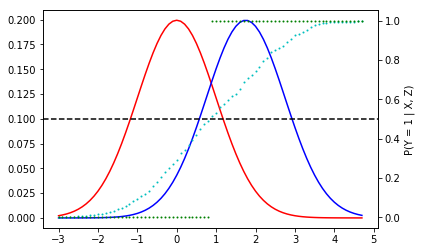

In [56]:
fig, ax = plt.subplots(1,1)
ax.plot(xs, pi0*norm.pdf(xs, mu0, sigma), c = 'r')
ax.plot(xs, (1 - pi0)*norm.pdf(xs, mu1[7], sigma), c = 'b')

ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
ax2.set_ylabel("P(Y = 1 | X, Z)")#, color = 'c') 
ax2.scatter(xs, np.array(props), s = 1, c = 'c')
ax2.axhline(y = 0.5, c = 'k', ls = '-.-')
ax2.scatter(xs, np.concatenate((np.zeros(int(len(xs)*pi0)), np.ones(int(len(xs)*(1 - pi0))))), c = 'g', s = 1)

In [57]:
L_stars = np.array([L_star_linear(pi0, mu0, i, sigma) for i in mu1])
EL = np.zeros(len(mu1))

for i in tqdm(range(len(mu1))):
    EL[i] = updated_prior_loss(pi0, mu0, mu1[i], sigma, M, acorn = 42)

In [58]:
product_loss = np.zeros(len(mu1))

for i in tqdm(range(len(mu1))):
    product_loss[i] = product_classifier(pi0, mu0, mu1[i], sigma, M)

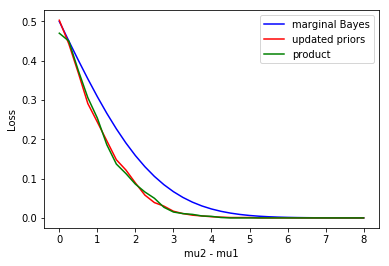

In [59]:
fig, ax = plt.subplots(1,1)
ax.plot(mu1 - mu0, L_stars, label = 'marginal Bayes', c = 'b')
ax.plot(mu1 - mu0, EL, label = 'updated priors', c = 'r')
ax.plot(mu1 - mu0, product_loss, label = 'product', c = 'g')
ax.set_xlabel('mu2 - mu1')
ax.set_ylabel('Loss')
ax.legend(loc = 'upper right')

From the chart above, it is clear that using the conditional independence directly, rather than via updated priors, in this parametric setting in which the parameters are known apriori is preferrable. 

Now, let's suppose the same setting as above except that $ f_{Z, i} $ is not known. That is, the parameters associated with the conditional densities of $ X $ are known whereas the parameters of the conditional densities of $ Z $ are unknown. Furthermore, assume $ \sigma_{Z, 0} = \sigma_{Z, 1} $ and $ \pi_{0} = 0.5 $ are known. While unknown, for simulations $ f_{X, i} \equiv f_{Z, i} $.

Then the plug-in version of the proposed classifier is given by

$$ \hat{g}_{X,Z}(j) = argmax_{k \in \{0, 1\}} \frac{\hat{f}_{Z,k}(Z_{j})}{\hat{f}_{Z, 0}(Z_{j}) + \hat{f}_{Z, 1}(Z_{j})} f_{X, k}(X_{j}) $$

In [103]:
# Simulations for n = 2, 5, 20, 50, 100

mc_its = 1000
ns = [2] #, 5, 20, 50, 100]
estimated_marginal = np.zeros((len(mu1), mc_its))

for i, mu in enumerate(tqdm(mu1)):
    for j in range(mc_its):
        X0 = np.random.normal(mu0, sigma, 2)
        X1 = np.random.normal(mu, sigma, 2)
        X = np.concatenate((X0, X1))
        Y = np.concatenate((np.zeros(len(X0)), np.ones(len(X1))))

        mu0_hat, mu1_hat, s_hat = parameter_estimates(X, Y)

        estimated_marginal[i][j] = L_star_linear_hat(pi0, mu0, mu0_hat, mu, mu1_hat, sigma)

estimated_marginal_means = np.mean(estimated_marginal, axis = 1)
estimated_marginal_stds = np.std(estimated_marginal, axis = 1, ddof = 1)/np.sqrt(mc_its)

In [119]:
np.random.seed(1)
mc_its = 50
ns = [50] #, 5, 20, 50, 100]
estimated_product = np.zeros((len(mu1), mc_its))

for i, mu in enumerate(tqdm(mu1[:1])):
    for j in range(mc_its):
        X0 = np.random.normal(mu0, sigma, 2)
        X1 = np.random.normal(mu, sigma, 2)
        X = np.concatenate((X0, X1))
        Y = np.concatenate((np.zeros(len(X0)), np.ones(len(X1))))

        mu0_hat, mu1_hat, s_hat = parameter_estimates(X, Y)
        
        estimated_product[i,j] = product_classifier_hat(pi0, mu0, mu0_hat, mu, mu1_hat, sigma, s_hat, 100, acorn = 4*i*j + i + j)    

estimated_product_means = np.mean(estimated_product, axis = 1)
estimated_product_stds = np.std(estimated_product, axis = 1, ddof = 1)/np.sqrt(mc_its)

0.00019989307215246708 2.035769501668619e-05 0
0.0005843772925591384 0.0006133063108918231 1
0.000740827147700747 0.00015681954188414115 0
0.0009579274379233856 0.0006024003607828354 0
0.0002834894675834885 0.0003095723831526292 1
4.1186511742307745e-05 1.784171024662356e-05 0
1.9255953849909862e-05 7.388734184379331e-05 1
0.00023516321266253004 5.275195399546982e-05 0
7.679517069543333e-05 0.00043059368140344094 1
0.00039929408195858533 0.00011145448718688359 0
0.00015360606110353988 0.0005140542729488646 1
0.0007034050983815682 0.0009029769670342564 1
0.00025831661063750397 0.00025785110554840934 0
0.0007197270591156364 0.00042454606475040343 0
0.0010776007044704108 0.0006275574526615276 0
0.0006911258533711254 0.0008219035604733624 1
0.0001182254958659237 0.0005353425927365752 1
0.00028591545946361643 0.00015320711426444582 0
0.0007734860011013732 0.0005977344715759736 0
0.0005832216711117121 0.001005895264381807 1
0.0009535090928684438 0.0007877160825807084 0
0.0005305261067186522 

1.6859786082770788e-05 1.67151073958394e-05 0
0.0005788940063853491 0.000738448869587229 1
0.0001459310241450204 8.258856090126951e-05 0
0.00016453942027864539 0.00010908981424928501 0
0.0005302059759023368 0.0005069997263582964 0
0.000817611045545856 0.0007312858022957281 0
0.0007012326595466776 0.0007621902602353215 1
0.0005582791638740534 0.0004030346960847506 0
0.00038742235616091066 0.0002649775779029618 0
0.0006531058728993625 0.000805018790557654 1
0.0004317937714099541 0.0005156966745771631 1
0.00024433707654450106 0.00022195300104433586 0
0.00022110471376348824 0.00032501556322999607 1
0.0009446462244318662 0.0009279035463531943 0
0.0006502779765668864 0.0007601413131597175 1
0.0009685071096558977 0.0009251208606932414 0
0.0005730578275264234 0.00042516426085072363 0
0.00010314897807007835 0.00013657062847095117 1
0.00022807489774857466 0.0003016039357481378 1
0.0006043420912859076 0.0007551022645746832 1
0.00043693084326394286 0.000505561734739391 1
0.0003599526302851657 0.00

0.001197171205378763 0.0012084495269486482 1
0.0009417212459002013 0.0009175440644484642 0
0.0007935579138999323 0.0007853682726271877 0
0.001082055468843615 0.00110187621229903 1
0.0008922468148706755 0.0008903680003516487 0
0.0006288829667998594 0.0006072629434799638 0
0.00047660730604386423 0.00045630305785126954 0
0.0003169331566550867 0.00033462662780454607 1
0.0011647365138312388 0.0011805987613677461 1
2.5525351585467578e-05 2.7108162595380372e-05 1
0.0012667654662125909 0.0012635463634309832 0
0.00023279670275360662 0.0001343361779454519 0
0.0007106920746235681 0.0005573898523058672 0
0.00045404063135028364 0.0005818446883880205 1
0.0008622848004079493 0.000561052743559219 0
0.0007948963346009574 0.0006963037498199458 0
0.00023539970841840753 0.0002184369881412616 0
0.0006637927650934632 0.00017464227693325684 0
0.0005627529543533204 0.0003306186525957093 0
0.00020906446036644092 0.00024039178879300323 1
0.0001810059297445924 0.0004193052653897067 1
0.000685291058193126 0.00047

0.0011922997041241233 0.0011173349825423216 0
0.00043269896288545396 0.00033849713805943383 0
0.0002445975538913939 0.00019514566361161835 0
0.0006915092508365584 0.0007082463246140793 1
0.00024501725946192773 0.00022185758149614678 0
0.0002315523953863225 0.00030389413918697843 1
0.0003091595420384716 0.00039864957132319925 1
0.0012330567323708746 0.001287666154862229 1
0.0010380065106188085 0.0009324344306386619 0
0.00034924383540996896 0.000444444554453795 1
0.0013118605674508534 0.0012898849962550858 0
0.0005431934949493352 0.00043550486065323333 0
0.0012584127605355538 0.0012741216059816193 1
0.0012567591609058217 0.0012240211894363007 0
0.0005508961097414523 0.0006693228220611869 1
6.4975164489935735e-06 4.198796528769909e-06 0
0.0003781214658148304 0.00034672739594117364 0
0.0001656412352224517 0.00014477154851326804 0
0.00082294170777946 0.0007121329385910088 0
0.0004905343997774541 0.00047300920982681986 0
2.8265501669946674e-05 2.2073161987508365e-05 0
0.001310589132235326 0.

0.00040731386178690884 0.000556935790340685 1
0.0003912875555663291 0.0009477576517589409 1
0.000468583621395953 0.001091126084145953 1
0.0009978104758216798 0.0010705476814910006 1
0.0008080023075162019 0.0002811627254886326 0
0.00036622970619521036 0.0004096738100792654 1
0.00024076381359061736 0.00024199602158745903 1
0.0003303062174237083 0.0009478478174124535 1
0.0008324214660059309 0.00037700422954481324 0
0.00119497343200507 0.0008994338057118135 0
0.00071440273795131 0.0011520384683514002 1
0.0008090076905426475 0.00023316379242811205 0
0.0002791175316269941 0.0007029632128809549 1
0.000764359364562222 0.00020867080184589252 0
0.0010592567926398808 0.00043151015931123344 0
0.0008200798759027591 0.00027311985142089044 0
0.0004446526036551137 0.000999730900546001 1
0.0006807638385312787 0.0005215285152556445 0
0.0009310011594904235 0.0011340144153912214 1
0.0004393073523005575 0.0010454487617767353 1
0.0005081510828540922 0.00010919526586266419 0
0.0006212472960633951 0.000594708

0.0004065912027840589 0.0001795503640869378 0
0.00032920498875682976 0.00015382004650344006 0
0.0012542952717825451 0.0004656891957881489 0
0.0010739420520931733 0.00030598982341005276 0
0.00010671950433311346 0.0005281535124722717 1
0.0008798592981065949 0.0002823487336766042 0
0.0009302902634666194 0.0005983616774467202 0
0.0012885719703756185 0.0005418479765326587 0
0.00036744939103198614 3.926468372270334e-05 0
0.0004506968358069527 0.0010441873452438123 1
0.0003030106756205266 0.000831140025370319 1
0.00020939529714504132 0.000725019976049923 1
0.001082473015006847 0.0007311491264121897 0
0.0009368063804401857 0.00029737716982485024 0
3.609892728127017e-05 9.88342005659993e-07 0
0.0009467503175288253 0.0006919379956063551 0
0.00021283029282289414 0.0008202099242806339 1
7.066556815779187e-05 0.0005360761992696889 1
0.00022753352379892926 0.000613763624157787 1
9.78367191649072e-05 0.0006423791245694524 1
9.734058018617856e-05 1.8518369293715807e-05 0
0.0003196871533832647 0.001076

0.0005397507637817272 0.001037395940775339 1
0.0005875902281168872 0.00020738413554792457 0
0.00027899034196092964 9.33199440410036e-05 0
0.0005812476778804849 0.0009494368649714414 1
0.00043904789946214347 0.00015277338393750132 0
0.0012853012402751496 0.001117219815958758 0
0.0002665250386456168 0.00017177215411856496 0
4.833928957598718e-05 7.236760570175325e-06 0
0.00042068469152248955 0.00037633875848099745 0
5.1623192542717444e-05 8.903885330775502e-06 0
0.000836997485508305 0.0003784941847702337 0
0.0007967980892921083 0.00032848365300585313 0
0.00037771346170237014 0.00014424996250006497 0
0.000155115829357005 7.202796494563908e-05 0
0.0002393414969215947 0.00019705406784777511 0
0.0002707740534762066 9.730343281156248e-05 0
0.0009974383419999386 0.0007147038211546149 0
0.00030177130687684224 7.941131520922691e-05 0
8.891942358641377e-05 0.0003299888384597723 1
0.000385334065963955 0.0007504602758836874 1
0.0008193681151029874 0.0003748420492376644 0
0.000189328656841475 4.2698

0.0003772804486579418 0.0004959124927401076 1
0.00012143052035161947 0.00015108010535202652 1
0.00039491173814215223 0.0003600687666820494 0
0.0008931448665497168 0.0009510145900514717 1
0.0005421707000530136 0.00066949576578769 1
0.00018745219797325848 0.00023004444579040545 1
0.00037386465016679124 0.0004860265874465448 1
0.0006825972134135768 0.0007993825117472419 1
0.000446558811417892 0.0005701633044014168 1
0.0002598795876504177 0.00031164934844790367 1
0.0005879913385849655 0.0007116793987698575 1
0.0004537506202996927 0.0004932273621005094 1
0.0005289970814136498 0.0006580520457309611 1
0.0007925875169554585 0.0008760963063011611 1
3.0004202973856316e-05 5.1431373249966785e-05 1
0.00013028839057468145 0.000141974625085899 1
0.0007625090430464437 0.0008487563719718776 1
0.00013343123209790783 0.00019807385890213236 1
0.0008772305943371545 0.0008719648905282034 0
0.0004922004028467199 0.0005827006997551459 1
0.0002455968569697464 0.0002893247214272834 1
0.0009317326470770821 0.00

0.002856146389106178 2.098559861267047e-06 0
6.255539600600604e-10 4.2514693749526066e-23 0
0.0026898466092362106 4.7396318106205585e-07 0
0.0007353327184208423 3.7279441966832896e-05 0
0.00041502691750495995 0.00010350367871065279 0
3.638005403465728e-07 0.0028609861889134208 1
0.0015800807071432723 4.448612083148003e-05 0
0.0026926600458638 2.4190589609489904e-06 0
0.001729274805996843 3.213460893383456e-07 0
0.0015570046415243181 4.4622810357634146e-05 0
0.001351427190927968 1.0038562002209231e-05 0
0.0018400879356688315 2.740068503933038e-05 0
0.0013123451627400412 3.4383446660655266e-08 0
0.002238970871631454 5.450476580824009e-08 0
5.482624739017407e-06 7.779087595344804e-15 0
3.185614106530692e-05 5.291633198472741e-14 0
1.3087137793133349e-12 1.404163524447152e-27 0
1.559684380655514e-05 1.1507726375457758e-14 0
0.0026693610770301924 4.644932236071786e-06 0
0.0023953156429068418 7.404661119239065e-06 0
6.368229691781614e-08 1.524006713671896e-19 0
3.695403041337626e-06 2.495852

3.0220995512741075e-05 0.0002413445270651582 1
0.000488098840151174 6.42934111676598e-05 0
0.0006410142432729962 0.0012293115584811796 1
0.0012225673214673884 0.0006415014160135142 0
0.00024871970171134653 0.00015305098795611425 0
0.0001471574623520392 0.0007393961712570561 1
0.0006546194803815319 0.0002302604024714333 0
0.00013419559218351786 0.0006341146297646915 1
0.000829409033009651 0.00017788965564377468 0
0.000789161269821265 0.00024016388445113413 0
0.00011645568301724173 0.00012761784260529623 1
9.242148131176539e-05 0.0005263229052780723 1
0.0004904976550127017 0.0004845695918931642 0
0.0010332120979075425 0.0009293241395590152 0
0.0009106673414498325 0.0011145566530680717 1
0.000930438260681493 0.0002861472874207906 0
5.934852770518902e-05 2.5570885048130216e-05 0
0.0003251332038933048 0.00014350748374019216 0
0.0003295251100528177 0.00042951975048140516 1
0.0003197104979759305 5.7126530168162784e-05 0
0.0006235490225426578 0.0007890007323120107 1
0.0005208772680059287 0.000

2.6202478350758928e-06 0.00029082487647456027 1
5.391902270114223e-06 0.0006803456464722861 1
9.3932307720241e-09 1.6225247235286837e-05 1
1.8251159037034023e-06 0.00013233766344952191 1
1.3502649471753037e-06 0.00032497850426023 1
4.856661336097883e-08 4.628756881672988e-05 1
3.607655381383428e-15 6.650229560449769e-10 1
4.893728998134528e-10 2.713158583037782e-06 1
7.016642596464461e-05 0.001362256684784703 1
8.706531953976463e-11 5.669181652986209e-07 1
3.5932845847660964e-08 1.4940280241161299e-05 1
1.4748453239706652e-05 0.0009681124515407365 1
6.34885485278013e-09 1.5071916308511975e-05 1
0.00025001573663252296 5.648880803228911e-06 0
1.1516025957132287e-06 0.00027978499077765706 1
2.5074552597921716e-13 4.543668444823891e-09 1
8.016359475223435e-09 1.1428738102513838e-05 1
1.043192934210157e-05 0.0005942778004423315 1
1.6712363924179547e-13 1.1010296173893155e-08 1
0.0014150445464013739 0.0008131547097079706 0
0.000244534022321227 0.001401909534999656 1
2.2067615201895705e-07 0.

0.000893628089636553 0.0006694756400100878 0
0.0006861611637512777 0.0008521725393283486 1
0.0004636344892903451 0.0006824445494315571 1
1.9163464325365452e-05 1.1188625660350543e-05 0
0.0004052056925845545 0.00034505512857044984 0
0.00040277959259703083 0.0006394229445171991 1
0.0008355697774500751 0.0005857066431370097 0
0.0006980748306897088 0.0004480971144332299 0
0.00027832191116632516 0.0002964849823772159 1
8.207892009656454e-05 0.0001104247707948152 1
0.0009789540927373868 0.0008260095584446772 0
0.0003515897890902453 0.0005025289944912595 1
0.000428383749904409 0.0006574116177461419 1
8.557280221012988e-05 0.00011432184475628334 1
0.0002403069163097225 0.0002361246545882681 0
0.00012280461527460667 7.900997485321551e-05 0
0.00029940451479710487 0.00032720426022914747 1
0.0009908249352138883 0.0009503563140142869 0
0.0008515699071184476 0.0007000922404147853 0
0.0002896411931777726 0.000296886119941423 1
0.0002698734151311776 0.00012217372014365602 0
0.0005463925261020267 0.000

6.234014005310245e-05 0.000845247418378927 1
0.0009627079272542529 0.0009805954868473503 1
0.0011069284064462817 0.0005440081452691309 0
0.0008703757424636977 0.0012200636572785753 1
0.0009708763006756526 0.00031327276027212126 0
0.0012294820735013795 0.0008047571710550679 0
5.1786135536700795e-05 0.0006533308603900475 1
1.3578392349544953e-05 9.702790731689942e-05 1
5.631310250296538e-05 0.0010584715279215603 1
0.0002260934557351805 0.00045158487652976776 1
1.164877351866018e-05 0.0003619250424105798 1
0.00045118826211289355 0.001411745637169989 1
0.0011531592365267948 0.00021072219883443478 0
0.0006632622927959028 0.0010555392428042323 1
0.000390049489907327 0.0010880371413085868 1
0.0006124300405232108 1.4160342056380246e-05 0
0.0009035609466647973 0.00029330797406831253 0
9.500374911882592e-05 0.0005242973593624067 1
0.0006673530757845109 0.0012364195505563964 1
0.0010764117722735708 0.00040803486011393596 0
0.0011362230477440266 0.0008585659685289072 0
2.4222517133981253e-05 9.093

0.00036589083276555645 0.000700222886189889 1
0.0007234150385757913 0.0008234416181950379 1
0.00014208885643453967 0.0004317733385296944 1
0.00040905980645475646 0.0008300147904255904 1
0.0008938418242813756 0.0009619448894098967 1
0.00013112124048516633 0.0004665502746250365 1
0.0005806821653550005 0.0010334126765446448 1
0.0009917242588112344 0.0009130298513487174 0
0.0008213011924712759 0.0006742417947655191 0
0.0009061298156443371 0.0003813705737069652 0
0.00018253369397578832 0.00015131248523753824 0
0.0006494471993368917 0.0010529623766840565 1
0.0006734815807675717 0.0007098859516833908 1
0.0006024833922757197 0.0010264180208083454 1
0.00020510044410263536 0.0006379797006942731 1
0.00037857415285096876 0.0008686357003235436 1
5.9609761549673384e-05 2.7704287323693213e-05 0
0.0008623373210984626 0.0005255166180156703 0
0.0006336905010013937 0.0008251342442935304 1
0.00022403471353468968 0.0004009603104995161 1
0.0002623357337674994 4.209956932540192e-05 0
0.00037751737810038 0.00

0.00021577013960830726 0.00027442322977424866 1
0.0010216844810400118 0.001084674646904756 1
8.316298704884458e-05 0.00011344400483769704 1
0.00037014858116184656 0.00029512618932604756 0
0.0007640622196411536 0.000872866209816301 1
0.0011622563417161673 0.0011855878333402645 1
0.000939150853624276 0.0009618012812252448 1
0.000193123899684008 0.0002473383570462515 1
0.00012887624100688404 0.00010467708928039745 0
5.0210015900012815e-06 3.042558003263379e-06 0
0.0008633254964749182 0.0008050002817204447 0
0.0005778190142891937 0.0004949661322271503 0
5.078819202979877e-05 3.709287163990562e-05 0
0.0007142472306574549 0.0007163768281455154 1
0.0009498265271477469 0.0008815532263858371 0
0.000743635320840145 0.0008506108445424198 1
0.0007405397043370268 0.0007163823276030421 0
0.0009098477204257332 0.0009899772775072814 1
0.0007988351300808055 0.0007877281391434074 0
0.0004025960533535436 0.0003215198250448116 0
0.0007784638413073767 0.0008150287486610649 1
0.001061972664008111 0.00113101

In [118]:
np.random.seed(1)
mc_its = 50
ns = [50] #, 5, 20, 50, 100]
estimated_update = np.zeros((len(mu1), mc_its))

for i, mu in enumerate(tqdm(mu1[:1])):
    for j in range(mc_its):
        X0 = np.random.normal(mu0, sigma, 2)
        X1 = np.random.normal(mu, sigma, 2)
        X = np.concatenate((X0, X1))
        Y = np.concatenate((np.zeros(len(X0)), np.ones(len(X1))))

        mu0_hat, mu1_hat, s_hat = parameter_estimates(X, Y)
        
        estimated_update[i,j] = updated_prior_hat_loss(pi0, mu0, mu0_hat, mu, mu1_hat, sigma, s_hat, 100, acorn = 4*i*j + i + j)  
        
estimated_update_means = np.mean(estimated_update, axis = 1)
estimated_update_stds = np.std(estimated_update, axis = 1, ddof = 1)/np.sqrt(mc_its)

0.027253587413952323 0.0026906632027011513 0
0.015725608506335764 0.016029106026533294 1
0.04056363465933108 0.008543841446250245 0
0.02749898115211984 0.017046419663816825 0
0.0076315106654768275 0.007949623178263986 1
0.0013042698565000055 0.0006122226660653983 0
0.0008291366647358652 0.002965095937465175 1
0.012689859739444358 0.0027147861354769945 0
0.0051101832271093555 0.029444685570228172 1
0.017739990544960695 0.004762652242474289 0
0.006453052772824069 0.02232587785024839 1
0.019306205811413724 0.025169401133862325 1
0.006955133860581286 0.007298161016155863 0
0.02078296979847793 0.012613327115251868 0
0.03148632010350415 0.01836166543353152 0
0.018791994368956996 0.022784178225979654 1
0.006344924858800612 0.029484581936740074 1
0.008442455313653478 0.004762628315502148 0
0.021281659480213166 0.016067720786559086 0
0.0170083096414535 0.02898223416743869 1
0.025893942608718874 0.021611425333250316 0
0.01929389780385797 0.006925795457964934 0
0.009269679291670871 0.034806267865

0.02765705821922864 0.018700671689648327 0
0.02212710649163412 0.02715662902262757 1
0.012684859678018483 0.014646437450178127 1
0.007211594706054614 0.0062307337606200795 0
0.013254603057539147 0.018931491587499377 1
0.02427161093605494 0.023643301457140047 0
0.018838288947890938 0.021590200504115736 1
0.025034751946898144 0.024057675145705018 0
0.027567897500980345 0.02028015911344135 0
0.003669411969426343 0.0045809624709856915 1
0.011329459939348627 0.015519692654643383 1
0.020881901184965326 0.02580959340028886 1
0.013805094983202959 0.016487839266825403 1
0.01538549897705491 0.020292021787505655 1
0.024442126676243188 0.016552152242791836 0
0.018058436576393028 0.0174458771330682 0
0.019802148719584634 0.02804453757134883 1
0.003415826283999267 0.003071697055132338 0
0.008436627408299407 0.013173067233501888 1
0.027351955820754514 0.022144370605604754 0
0.029301114135522156 0.01854520747742276 0
0.023505899388259966 0.025038816157254017 1
0.01947280621150862 0.030190206134441858 

0.013252733825193824 0.01645957194975533 1
0.026750181773719954 0.017140914244176478 0
0.02297254626182319 0.019787131190952607 0
0.006785483086615995 0.0059828798891448315 0
0.039468954014015 0.010393848811639758 0
0.018328019369140646 0.010425456082473625 0
0.006076338617156237 0.007353214487092468 1
0.007089435352053108 0.017061001905307148 1
0.02082015807381836 0.014201231723065482 0
0.009689666360909656 0.0019005785407796843 0
0.031026834761480947 0.01663717000953657 0
0.025042249848968086 0.024388499357973437 0
0.008279654768704485 0.009531325384733601 1
0.016560673233395575 0.033206592965653633 1
0.03973198511101919 0.007373948338064013 0
0.033357029368829866 0.01351224124146916 0
0.03621025925840338 0.01146044602798544 0
0.014740771268153636 0.03483354932984341 1
0.019853460454269677 0.027340775438725578 1
0.04085341159188735 0.008367424994139274 0
0.03235849431788172 0.012773041981650498 0
0.01528119443218588 0.03239641058767411 1
0.01794493291645126 0.024202679360696228 1
0.0

0.02814390709352519 0.00023743194262348553 0
4.8852647837733734e-05 0.004227563013811252 1
0.03041322346302187 0.0192396013321874 0
0.03801146906343566 0.008536185519697382 0
0.018444026600314575 0.020583907261993394 1
0.019937974742805266 0.024022628825518495 1
0.008434271498067062 0.03494269620128389 1
0.0012129917985097265 0.004907037854576131 1
0.022233569514185144 0.02761323643857761 1
0.003756560716350415 0.04459800274905065 1
0.011989976617149227 0.028197892298547314 1
0.007888374772177582 0.016578757783368647 1
0.009527210878959264 0.0313595951800836 1
0.033951128534675204 0.015743486561897422 0
0.037919430278189545 0.003838275758976029 0
0.004444995112017864 0.024979879822333864 1
0.008427547361230458 0.00045261729706594324 0
0.02549552193085312 0.020601926777415767 0
0.017586424711331476 0.02643751695767712 1
0.017138120626628485 0.025782150557820467 1
0.010519703051821703 0.0005507776511217257 0
0.013032082969335734 0.036262228907915535 1
0.038505382811457434 0.0112883081542

0.023931994366879684 0.02590280678047916 1
0.0182403640109287 0.024232813852241502 1
0.015172686261333815 0.011246180048174468 0
0.01646736104206059 0.013400451846407837 0
0.019810382976331132 0.023451221488062165 1
0.017405377160992358 0.009135521895921199 0
0.007570811255730641 0.004553622364141912 0
0.0206412343424888 0.022728838654604573 1
0.022513050697274776 0.02577294447855913 1
0.026467610936028906 0.02336890889972094 0
0.009096763937237939 0.011336262226857978 1
0.01447194901973084 0.03506762908163362 1
0.01908939405046224 0.029073827644104707 1
0.013883887083817924 0.015389073895735102 1
0.026310651149111023 0.022924565346033435 0
0.014118332946715743 0.01783280974872107 1
0.018916297384464452 0.02305174640109771 1
0.014581995502479048 0.011604733663985487 0
0.010867579337604655 0.0068409552216232294 0
0.022150258970095822 0.023311107241440275 1
0.02249078934425045 0.02059826516490923 0
0.022018926356905184 0.026867975748956628 1
0.002573156148609987 0.0030213727517427167 1
0

0.024999990300349707 0.018323973855703373 0
0.02640544372699318 0.023462064499252366 0
0.007714932129654071 0.011119819174723761 1
0.01605069098116923 0.0337550874820786 1
0.027495547517031326 0.022368674696381357 0
0.010816441172789121 0.02790734106350167 1
0.023672377134067453 0.023208832980412097 0
0.012780729786792306 0.02690647878560652 1
0.025340511918517883 0.021389729351608766 0
0.004344247241768172 0.0038336776785180184 0
0.0220617010908568 0.026342643100310162 1
0.028602680454060794 0.020648502418997426 0
0.011572384156980753 0.020781081934567562 1
0.03380385844234678 0.009104446024540849 0
0.02461124657964506 0.024302395219690767 0
0.009540626085910974 0.009842995158987828 1
0.028465973123678982 0.018670678392654044 0
0.016915842627220293 0.03292883039167893 1
0.025918234580272426 0.018088800079846312 0
0.024864992562172363 0.0240562293188399 0
0.015185323002921391 0.014234102659994538 0
0.007967902024354252 0.007535874163871658 0
0.02367887860080502 0.021602182121322113 0
0

0.014259496832374029 0.034132921477484056 1
0.005201247467632309 0.014060116746374484 1
0.023081591898599648 0.025465926320832617 1
0.016731562504820517 0.02414466151800101 1
0.016239643181946033 0.0261835704236866 1
0.019285521583604075 0.012732424844102834 0
0.014516345993756232 0.016158742857017877 1
0.029644685209856508 0.018735414087558713 0
0.01783328668537695 0.02382477125590517 1
0.008794415231339838 0.011325229031536125 1
0.019863645566358234 0.029095410910717188 1
0.019035150518968612 0.019453305074973927 1
0.02162492743187271 0.027012912491775048 1
0.007029136270118326 0.01682005063157147 1
0.008441091398278207 0.012438172608789766 1
0.029736832324850793 0.01861313101779249 0
0.024874632050202603 0.02221985019508969 0
0.03416278967427405 0.01517057691454959 0
0.01521851407062219 0.020135731674213897 1
0.005553598280656054 0.00894281590314284 1
0.007836833218648248 0.008359846863490027 1
0.007331627337227199 0.011108937482475519 1
0.01816934627182377 0.025896298001491572 1
0.

0.008171395481947627 0.007668051475546718 0
0.029587071272231515 0.004970790490795145 0
0.03206358159239655 0.014335255756219708 0
0.035304550637852525 0.01455185000310589 0
0.02079399185802685 0.0076866713306987244 0
0.005072871404871554 0.002504132040792778 0
0.004949354573686318 0.0038463244149319477 0
0.01723377348563936 0.005961031029885055 0
0.022050880412471743 0.015439252910059095 0
0.039056760492534766 0.010233918692360643 0
0.01053817806474093 0.038983228296211 1
0.011456086617219223 0.02170086868161981 1
0.030909682509425763 0.013945328088248823 0
0.03686801678301753 0.008433440623670418 0
0.033706269102153436 0.015799453863171747 0
0.007359037371238477 0.012244426033540895 1
0.018284660019114753 0.018628122363449767 0
0.009915180883650428 0.007794047391832039 0
0.022039112108966603 0.026160978894437033 1
0.02825436395557689 0.021571156014781243 0
0.035834768172892925 0.014032985382342957 0
0.040639777412076174 0.007384206380237383 0
0.0011512802787696055 0.00097602072598398

0.006624775241888602 0.008652437567043056 1
0.012010494878843073 0.010533111734388782 0
0.023726536158297378 0.025412127749928137 1
0.022285819967053463 0.027559038072548787 1
0.009128280964177954 0.011680612870177024 1
0.02086648887260552 0.027360128076257394 1
0.021832558096752476 0.02531396621196886 1
0.021810953140811704 0.027925083918557147 1
0.011024354362730571 0.013725366972418203 1
0.02237535863242915 0.027189093807222346 1
0.011722041127937934 0.01227525086648825 1
0.021572955279150256 0.02663136494976439 1
0.022751636173852865 0.02537178439619111 1
0.012983844407128664 0.02168140292895967 1
0.004121139396610407 0.00476151003626729 1
0.0223452527136752 0.025129929731405994 1
0.019449546712864252 0.02909626393337122 1
0.022254134906759405 0.02178933380790548 0
0.01831718234925614 0.02213870557912327 1
0.009749374963558755 0.011963356140548354 1
0.02358311674236591 0.02394757537916098 1
0.021843363634587155 0.027704317806989478 1
0.02178663485679744 0.026749629136778957 1
0.023

0.021587313065525904 0.0035318260488471785 0
0.0347067817880022 0.00011429782603013404 0
0.04986640230219361 8.459235855933394e-07 0
0.04833936640524911 1.7341410155705363e-06 0
0.01948835033618903 2.0748293715675627e-07 0
0.04971383709181105 1.2016386029398877e-12 0
0.037253821269890366 0.0008182598206763486 0
0.016830232601351622 0.011899138498383569 0
0.04608834324009075 0.003778568637584585 0
0.039856792440476636 6.818514362320398e-07 0
0.01800046515720477 1.4951884196856818e-05 0
0.015001451240890222 0.013302455048224538 0
0.04679189926377224 1.7796790806016187e-08 0
0.021873121651709578 0.00044961625506002867 0
0.03598501248450257 0.00044679283921191475 0
0.03841347391302682 1.0059221086829001e-06 0
0.04888546335916527 3.615672847750146e-05 0
0.04395437462864817 2.9425892723674154e-15 0
0.045374321359594134 7.891267511035053e-06 0
0.02650691404583177 0.0013905432074122733 0
0.02214293594226501 0.0053396349246958635 0
6.219868296251823e-06 0.048591830607495334 1
0.0483874532403826

0.003715383542444091 0.0025643670184330954 0
0.013703077171594004 0.01837207892413678 1
0.002194120746925241 0.009667998860622643 1
0.00763437245509392 0.006718889956041032 0
0.028144554104000758 0.009980775365175316 0
0.019775694559764963 0.02850427015381438 1
0.033400701631495236 0.01645090836010691 0
0.00014507941308192107 0.0006613373935842006 1
0.027222355163154157 0.003477106290089322 0
0.028560455779919322 0.007346080261947515 0
0.024369229340231748 0.002459280898038762 0
0.013242518122204209 0.026595555243596643 1
0.011137686798121181 0.038708853747065855 1
0.00497736331040666 0.0027647275365674634 0
0.013502569076656727 0.029347565772230192 1
0.0039372138295388414 0.019126779408379313 1
0.01434614888878085 0.01100343372743292 0
0.011810000088376323 0.0024580196668192097 0
0.03674756270840788 0.009665706414149189 0
0.0278925099849294 0.004974703857860657 0
0.03355818319290976 0.016287124866774857 0
0.030273885397740015 0.01884969496646132 0
0.020691522953351298 0.00889638351407

0.013819944518447373 0.013723933520300269 0
0.00582879679144641 0.005787416760474209 0
0.005694795844790653 0.005596842376058635 0
0.01474051728795535 0.015116396294209722 1
0.024222806469935913 0.023609915140330253 0
0.02547175812340054 0.02315943228819981 0
0.011274587443538221 0.012042363741157795 1
0.006198298496563461 0.006778644951624313 1
0.022044411609324147 0.022986763999170857 1
0.009193164474278327 0.009923740042635245 1
0.00962921496917951 0.009951448952339908 1
0.010505976652754358 0.009913644335555298 0
0.02700146538478864 0.0228511263939054 0
0.012855735763612094 0.012587927361383783 0
0.0030891983335827287 0.003575430779190747 1
0.0110126508790896 0.013993581526977238 1
0.01713215634098956 0.015155482210315076 0
0.017888804652128144 0.014559947576533352 0
0.018434489027687337 0.017371857708136304 0
0.01995889424093818 0.021665523301117057 1
0.024062018018867943 0.02553323314159309 1
0.024626411943164894 0.025053238200905412 1
0.015496282940118277 0.014805736708039694 0


0.03157581620411079 0.018130288203179676 0
0.027052962774009454 0.015160316232725781 0
0.044427339873764085 8.604559959480591e-07 0
0.046169482996996226 0.0009770103214807601 0
0.02000261678195582 0.00014546666131033854 0
0.0002593235936732046 0.041638256002088835 1
0.015267012311045356 0.002122459673689857 0
0.012290725293565109 1.0904417811095478e-06 0
0.04299681345484183 9.398578496267174e-10 0
0.0015496745564608566 0.042547152967830355 1
0.004119456379501728 0.0006577051740000727 0
0.0011982406733644006 0.04308165854135986 1
1.103262164130487e-06 0.02133206297141487 1
0.031006428189518973 5.593332448646226e-07 0
0.03640370546294905 0.009922417173215792 0
0.03565183661556694 0.00339753626371788 0
0.038929837892520476 0.007201328770615133 0
0.024280463127780143 6.942616033815028e-08 0
0.045628097762793494 0.0002267701828243742 0
0.04934604125973194 0.0004969918503821952 0
0.002745420744233388 0.04510235958018741 1
0.049835051543441276 5.602376810928685e-07 0
0.0024783624395868648 9.1

0.01686715804855603 0.014998664753648994 0
0.02583262783084768 0.023872127455114273 0
0.02439211680410137 0.025294522705819687 1
0.007147075923490605 0.014272337706783508 1
0.0013490918737014681 0.0018633806409833178 1
0.015615620823539173 0.024432398138069807 1
0.015532506959784633 0.017301847158200916 1
0.022220781351935608 0.027558864380108936 1
0.028460993815959307 0.020675843158083834 0
0.012101254269745065 0.009623148171349953 0
0.01355035829721144 0.007877081498109647 0
0.02279754352293185 0.026463319597666807 1
0.009864009180727011 0.012299270140689903 1
0.020029401556708896 0.019237187876587937 0
0.0036100005003634216 0.004938052549620267 1
0.025777595531179733 0.02400220725702805 0
0.01896912935508839 0.01477880773590389 0
0.013277786319024168 0.02527618935800928 1
0.019053905852015936 0.029855573959321483 1
0.011755334884248519 0.013568483225155052 1
0.020427188381158104 0.028971405617069408 1
0.019377622284293367 0.025916043305063755 1
0.02523916436838796 0.0156532084099434

0.04696308444926458 1.7570827109345024e-07 0
0.04409875200137245 6.457116497416378e-05 0
0.005909811484170595 0.022920844720546885 1
0.0040455167155215715 0.00010039666928711337 0
0.049685015679658794 1.6265826565400787e-09 0
0.04957784057911635 6.60327055124527e-08 0
0.01933317577886112 1.3892252926212182e-09 0
0.046815658612145046 5.24352883721828e-13 0
0.040430342701015476 1.7285777380739252e-12 0
0.03447064964625721 7.424401128746142e-16 0
0.0402164698297031 1.1912211232977674e-09 0
0.0025941063502327574 0.045651357458657386 1
0.016530578113832038 3.375070693080692e-08 0
0.041771364454049095 5.168660308682726e-07 0
0.04451905954908957 5.182682433163893e-06 0
0.009380210006785862 1.5385089694616103e-05 0
0.00018184272442334603 0.0479116778886157 1
0.00047940206613609587 0.00478790303223628 1
0.049452999124674206 0.00020159688748457757 0
0.048890604449016675 4.6895816735450705e-05 0
2.5067601598722892e-06 0.015052348268678397 1
0.02762160917662862 1.7824027758268737e-05 0
0.045436219

0.018526297265199488 0.030280276840259693 1
0.019802168311842543 0.010380855436516326 0
0.013616661809419747 0.01781484528223804 1
0.006110842129849903 0.00952156267443526 1
0.018646867359359425 0.02879048703087135 1
0.015334477161816297 0.02258612946148662 1
0.028699256885943856 0.01863400082047292 0
0.012321953598035935 0.03533282910619866 1
0.018190893845232516 0.0264578572661415 1
0.03016048458456157 0.018279711226850046 0
0.02094149132540039 0.019945197715500868 0
0.013729519273715289 0.022316892963651982 1
0.015568014177757926 0.029334554596793606 1
0.01832300677003943 0.023280357261273917 1
0.011882489642509451 0.02403794239510525 1
0.013028603491263998 0.036820918238720836 1
0.009210780427474936 0.016844627478068912 1
0.025064440293958115 0.016063947949660873 0
0.0077723840464131826 0.017889228147575726 1
0.01260701839903603 0.03264013249364215 1
0.021857163029336015 0.027161727283311125 1
0.0037919415804134704 0.012663986541357884 1
0.005165300310820353 0.0022470828467669648 0

0.01453261622485135 0.03437758731617259 1
0.0357718483356475 0.0072893532154124285 0
0.022145859700075602 6.066309924888794e-05 0
0.003576918347555571 0.00021874826383646364 0
0.017729302737388895 0.025316609449905384 1
0.005068561370610964 0.028714489422449616 1
0.0313525359736611 0.015965422138757384 0
0.03220354049705022 0.003315617343802657 0
0.022100169539833393 0.024732435139326825 1
0.009076821313524828 0.005959418180120516 0
0.03063030600104058 0.001926947164401776 0
0.008100062246114884 0.04171104281452609 1
0.03906286743528644 0.010598557889582319 0
0.03703079717327596 0.012192591605580127 0
0.01450251643043096 0.004914995880856849 0
0.0062471388373202645 0.043620500207357416 1
0.027294364801606047 0.0022875697677136285 0
0.013810510179872724 0.0003703654594494334 0
0.04526231646019327 0.0005914983094953516 0
0.004676946966824391 0.02593069556258947 1
0.04347453059385412 0.0047983538521773955 0
0.018115902259396317 0.030968106011157678 1
0.037389496842037455 0.010961630996176

In [120]:
np.sum(estimated_product[0] == estimated_update[0])

50

Text(0.5, 1.0, 'n = 4, sigma = 1')

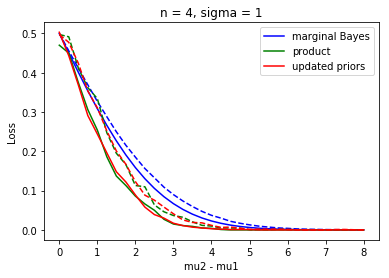

In [65]:
fig, ax = plt.subplots(1,1)
ax.plot(mu1 - mu0, L_stars, label = 'marginal Bayes', c = 'b')
ax.plot(mu1 - mu0, estimated_marginal_means, c = 'b', ls = "--")
ax.plot(mu1 - mu0, product_loss, label = 'product', c = 'g')
ax.plot(mu1 - mu0, estimated_product_means, c = 'g', ls = "--")
ax.plot(mu1 - mu0, EL, label = 'updated priors', c = 'r')
ax.plot(mu1 - mu0, estimated_update_means, c = 'r', ls = "--")

ax.set_xlabel('mu2 - mu1')
ax.set_ylabel('Loss')
ax.legend(loc = 'upper right')
ax.set_title('n = 4, sigma = 1')

In the small scale and small $ n $ regime, both the proposed classifier and the "product" classifier perform similarly. Both outperform the noise-free marginal Bayes' for large enough $ \mu_{2} - \mu_{1} $. This is again attributable to the fact that both classifiers are of the same form and are constructed to take advantage of the generative models. An interesting next question is how the two classifiers perform in a misspecified setting. In particular, let $ f_{X, i} $ be defined as above and let $ f_{Z, i} = \epsilon N(\mu_{i}, \sigma^{2}) + (1 - \epsilon) N(\mu_{i}, \tau^{2}) $ with $ \sigma < \tau $.

In [76]:
np.random.seed(1)
mc_its = 50
ns = [2] #, 5, 20, 50, 100]
estimated_product2 = np.zeros((len(mu1), mc_its))

for i, mu in enumerate(tqdm(mu1)):
    for j in range(mc_its):
        X0 = np.random.normal(mu0, sigma, 2)
        X1 = np.random.normal(mu, sigma, 2)
        X = np.concatenate((X0, X1))
        Y = np.concatenate((np.zeros(len(X0)), np.ones(len(X1))))

        mu0_hat, mu1_hat, s_hat = parameter_estimates(X, Y)
        
        estimated_product2[i,j] = product_classifier_hat(pi0, mu0, mu0_hat, mu, mu1_hat, sigma, s_hat, 100, epsilon = 0.4, acorn = 4*i*j + i + j)    

estimated_product2_means = np.mean(estimated_product2, axis = 1)
estimated_product2_stds = np.std(estimated_product2, axis = 1, ddof = 1)/np.sqrt(mc_its)

In [77]:
np.random.seed(1)
mc_its = 50
ns = [2] #, 5, 20, 50, 100]
estimated_update2 = np.zeros((len(mu1), mc_its))

for i, mu in enumerate(tqdm(mu1)):
    for j in range(mc_its):
        X0 = np.random.normal(mu0, sigma, 2)
        X1 = np.random.normal(mu, sigma, 2)
        X = np.concatenate((X0, X1))
        Y = np.concatenate((np.zeros(len(X0)), np.ones(len(X1))))

        mu0_hat, mu1_hat, s_hat = parameter_estimates(X, Y)
        
        estimated_update2[i,j] = updated_prior_hat_loss(pi0, mu0, mu0_hat, mu, mu1_hat, sigma, s_hat, 100, epsilon = 0.4, acorn = i*j + i + j)  
        
estimated_update2_means = np.mean(estimated_update2, axis = 1)
estimated_update2_stds = np.std(estimated_update2, axis = 1, ddof = 1)/np.sqrt(mc_its)

/mnt/c/Users/hhelm/virtualenvs/d3m/lib/python3.6/site-packages/ipykernel_launcher.py:182: RuntimeWarning: invalid value encountered in double_scalars


Text(0.5, 1.0, 'n = 4')

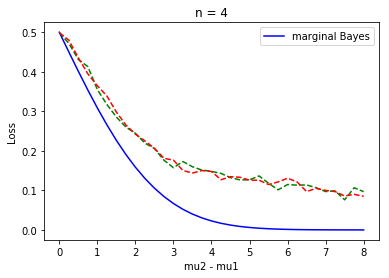

In [79]:
fig, ax = plt.subplots(1,1)
ax.plot(mu1 - mu0, L_stars, label = 'marginal Bayes', c = 'b')
#ax.plot(mu1 - mu0, estimated_marginal_means, c = 'b', ls = "--")
#ax.plot(mu1 - mu0, product_loss, label = 'product', c = 'g')
ax.plot(mu1 - mu0, estimated_product2_means, c = 'g', ls = "--")
#ax.plot(mu1 - mu0, EL, label = 'updated priors', c = 'r')
ax.plot(mu1 - mu0, estimated_update2_means, c = 'r', ls = "--")

ax.set_xlabel('mu2 - mu1')
ax.set_ylabel('Loss')
ax.legend(loc = 'upper right')
ax.set_title('n = 4')

I clearly do not understand what regime my classifier will outperform the natural product classifier. Need to talk to Jovo/CEP.